In [1]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [118]:
yf.pdr_override()
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

stock = 'ANTM.JK'
today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = pdr.get_data_yahoo(tickers,start=start_date, end=today)
panel_data.head(5)


AttributeError: 'DataFrame' object has no attribute 'today'

In [49]:
data_close = panel_data["Adj Close"]
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,antm,asii,icbp,jsmr
count,3225.00000,3225.00000,3225.00000,3225.00000
mean,1130.94089,5535.38051,6108.67065,4489.46092
std,576.18312,1103.17970,2825.91028,1157.56689
min,274.09692,2290.73950,1283.99255,1398.53259
25%,740.15723,4960.83838,3946.94482,3770.00000
50%,929.10339,5624.34473,7099.00879,4573.74121
75%,1440.12781,6326.53076,8323.28027,5276.22754
max,3117.91113,7761.65576,11525.49121,6832.19678


# PLOT SEMUA SAHAM

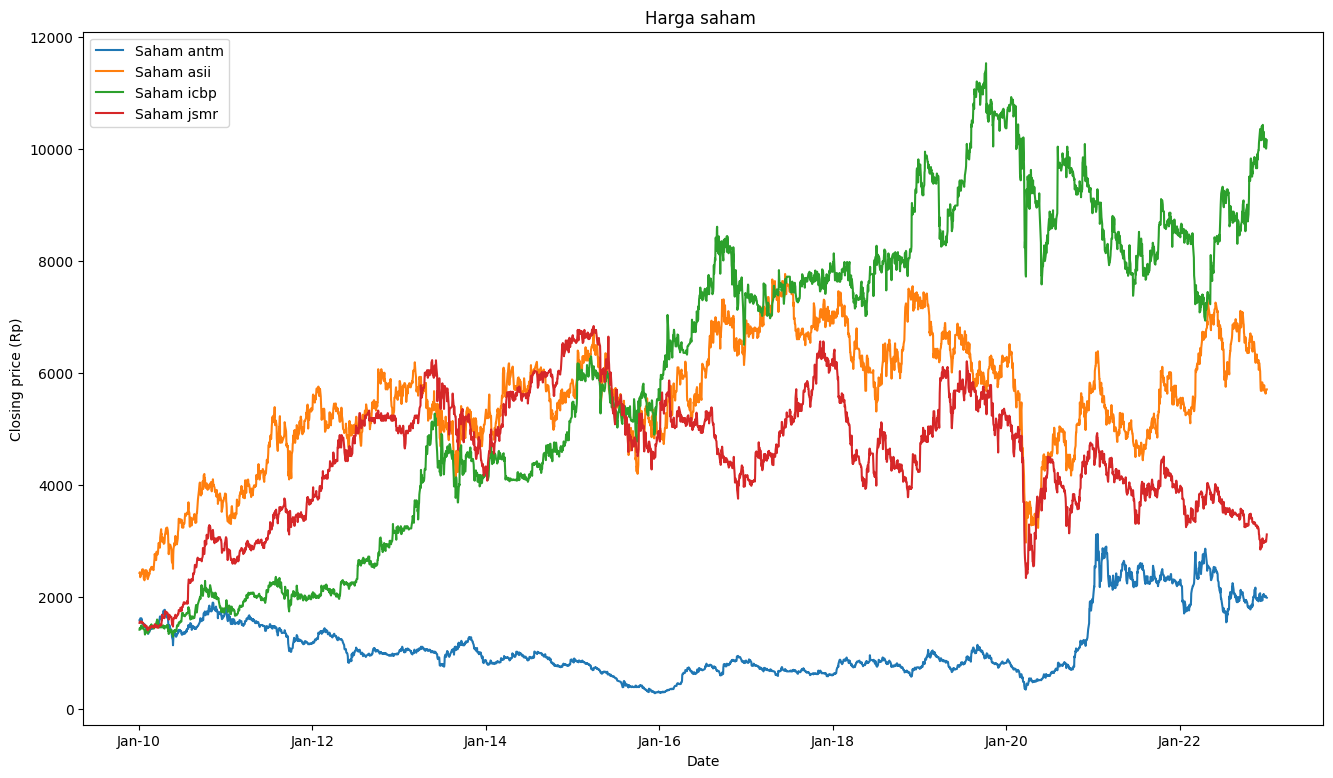

In [119]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in ['antm', 'asii', 'icbp', 'jsmr']:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

# SLIDING WINDOWS

In [6]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX

In [7]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE FUNCT

In [8]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# PEMBULATAN

In [11]:
def pembulatan(data,number):
    return np.round(data,number)

# METRIC EVALUATION

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham, number):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))
    print("round_up")
    print("mae score: "+str(pembulatan(mean_absolute_error(preds, y_test),number)))
    print("r2 score "+str(pembulatan(r2_score(preds, y_test),number)))
    print("mape score "+str(pembulatan(mean_absolute_percentage_error(preds, y_test),number)))
    print("rmse score "+str(pembulatan(np.sqrt(mean_squared_error(preds, y_test)),number)))

# VANILA MODEL

In [9]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# BIDIRECTIONAL LSTM

In [18]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

# CNN-LSTM

In [19]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [20]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [21]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

# CONVLSTM

In [22]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [23]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

# RNN

In [201]:

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

def train_model_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

# SPLIT SIZE

In [28]:
def data_size(data):
    train_size = int(len(data) * 0.80)
    test_size = len(data) - train_size
    return train_size, test_size

# STOCK MODELING

## ANTM

### VANILA

In [380]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm = pd.DataFrame(data_close.antm)
df_antm = pd.DataFrame(scaler.fit_transform(df_antm), columns = ['antm'])

In [381]:
#reset index
# df_antm = reset_index_data(df_antm)
antm_train_size, antm_test_size = data_size(df_antm)
train_antm = df_antm.iloc[:antm_train_size,:].values
test_antm = df_antm.iloc[antm_train_size:len(df_antm),:].values


#data to supervised
X_train_antm, y_train_antm = split_sequence(train_antm, 2)
X_test_antm, y_test_antm = split_sequence(test_antm, 2)
        
# X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [382]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 8)                 320       
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 4s 7ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 2/200
258/258 [==============================] - 1s 4ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0258 - val_mae: 0.0258
Epoch 3/200
258/258 [==============================] - 1s 4ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0254 - val_mae: 0.0254
Epoch 4/200
258/258 [==============================]

In [383]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm',4)

21/21 [==============================] - 0s 3ms/step
Matriks score for antm
mae score: 0.01685535305546571
r2 score 0.9860192387836259
mape score 0.03142844760017941
rmse score 0.026419780173973572
round_up
mae score: 0.0169
r2 score 0.986
mape score 0.0314
rmse score 0.0264


In [384]:
preds_antm_train = model_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_train,y_train_antm,'antm',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for antm
mae score: 0.005647793241561502
r2 score 0.9952004766890814
mape score 0.03614494651371344
rmse score 0.008249663360865762
round_up
mae score: 0.0056
r2 score 0.9952
mape score 0.0361
rmse score 0.0082


### BILSTM

In [385]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_40 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 8s 10ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0259 - val_mae: 0.0259
Epoch 2/200
258/258 [==============================] - 2s 8ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0118 - val_mae: 0.0118
Epoch 3/200
258/258 [==============================] - 1s 6ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0144 - v

In [386]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm',4)

21/21 [==============================] - 1s 2ms/step
Matriks score for antm
mae score: 0.017450205629956878
r2 score 0.9850253096312557
mape score 0.031666678027604506
rmse score 0.027187388217067773
round_up
mae score: 0.0175
r2 score 0.985
mape score 0.0317
rmse score 0.0272


In [387]:
preds_antm_bidirectional_train = model_bidirectional_antm.predict(X_train_antm)
matriks_evaluate(preds_antm_bidirectional_train,y_train_antm,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.005937620539211828
r2 score 0.994956451117887
mape score 0.03927964113275302
rmse score 0.008487858934791483
round_up
mae score: 0.0059
r2 score 0.995
mape score 0.0393
rmse score 0.0085


### CNN-LSTM

In [405]:
df_antm_cnn = pd.DataFrame(data_close.antm)
df_antm_cnn = pd.DataFrame(scaler.fit_transform(df_antm_cnn), columns = ['antm'])

In [407]:
antm_train_size_cnn, antm_test_size_cnn = data_size(df_antm_cnn)
train_cnn = df_antm_cnn.iloc[:antm_train_size_cnn,:].values
test_cnn = df_antm_cnn.iloc[antm_train_size_cnn:len(df_antm_cnn),:].values

#data to supervised
X_train_antm_cnn, y_train_antm_cnn = split_sequence(train_cnn, 2)
X_test_antm_cnn, y_test_antm_cnn = split_sequence(test_cnn, 2)
#split to train and test
# X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [408]:
cfg_antm_cnn = [8,'relu',2,1,0.01,8,200]
model_cnn_antm,history_cnn_antm_model = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_30 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_43 (Dense)            (None, 1)                 9         
                                                     

In [409]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.01967925803367447
r2 score 0.9828908887675315
mape score 0.035442224463127045
rmse score 0.029042639414256062
round_up
mae score: 0.0197
r2 score 0.9829
mape score 0.0354
rmse score 0.029


In [411]:
preds_antm_cnn_lstm_train = model_cnn_antm.predict(X_train_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm_train,y_train_antm_cnn,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.00678963683964912
r2 score 0.9934045709917124
mape score 0.046385750732538554
rmse score 0.009733252080896435
round_up
mae score: 0.0068
r2 score 0.9934
mape score 0.0464
rmse score 0.0097


### CONVLSTM

In [393]:
df_antm_conv = pd.DataFrame(data_close.antm)
df_antm_conv = pd.DataFrame(scaler.fit_transform(df_antm_conv), columns = ['antm'])

In [169]:
antm_train_size_conv, antm_test_size_conv = data_size(df_antm_conv)
train_conv = df_antm_conv.iloc[:antm_train_size,:].values
test_conv = df_antm_conv.iloc[antm_train_size:len(df_antm),:].values

#data to supervised
X_train_antm_conv, y_train_antm_conv = split_sequence(train_conv, 2)
X_test_antm_conv, y_test_antm_conv = split_sequence(test_conv, 2)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [170]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_3 (Flatten)         (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 7s 7ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0072 - val_mae: 0.0072
Epoch 2/200
258/258 [==============================] - 1s 4ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0157 - val_mae: 0.0157
Epoch 3/200
258/258 [==============================] -

In [171]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for antm
mae score: 0.031200170196642445
r2 score 0.9668194961437925
mape score 0.05787047678264966
rmse score 0.04181374329152421
round_up
mae score: 0.0312
r2 score 0.9668
mape score 0.0579
rmse score 0.0418


In [172]:
preds_antm_conv_lstm_train = model_conv_antm.predict(X_train_antm_conv)
matriks_evaluate(preds_antm_conv_lstm_train,y_train_antm_conv,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.01353878413072829
r2 score 0.966517395541238
mape score 0.07495670932675856
rmse score 0.01892995503076707
round_up
mae score: 0.0135
r2 score 0.9665
mape score 0.075
rmse score 0.0189


### RNN

In [195]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm_rnn = pd.DataFrame(data_close.antm)
df_antm_rnn = pd.DataFrame(scaler.fit_transform(df_antm_rnn), columns = ['antm'])

In [198]:
antm_rnn_train_size, antm_rnn_test_size = data_size(df_antm_rnn)
train_rnn = df_antm_rnn.iloc[:antm_rnn_train_size,:].values
test_rnn = df_antm_rnn.iloc[antm_rnn_train_size:len(df_antm_rnn),:].values

#data to supervised
X_train_antm_rnn, y_train_antm_rnn = split_sequence(train_rnn, 2)
X_test_antm_rnn, y_test_antm_rnn = split_sequence(test_rnn, 2)

X_train_antm_rnn = reshape_data(X_train_antm_rnn,1)
X_test_antm_rnn = reshape_data(X_test_antm_rnn,1)


In [202]:
cfg_antm_rnn = [8,'relu',2,1,0.1,8,200]
model_antm_rnn,history_antm_model_rnn  = train_model_rnn(X_train_antm_rnn,y_train_antm_rnn,cfg_antm_rnn)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 3s 6ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 2/200
258/258 [==============================] - 1s 4ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0213 - val_mae: 0.0213
Epoch 3/200
258/258 [==============================] - 1s 3ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0065 - val_mae: 0.0065
Epoch 4/200
258/258 [==============================] -

In [376]:
preds_antm_rnn = model_antm_rnn.predict(X_test_antm_rnn)
matriks_evaluate(preds_antm_rnn,y_test_antm_rnn,'antm',4)

21/21 [==============================] - 0s 4ms/step
Matriks score for antm
mae score: 0.04603685566253975
r2 score 0.9401848547424274
mape score 0.06418790184997934
rmse score 0.06423766270595317
round_up
mae score: 0.046
r2 score 0.9402
mape score 0.0642
rmse score 0.0642


In [377]:
preds_antm_rnn_train = model_antm_rnn.predict(X_train_antm_rnn)
matriks_evaluate(preds_antm_rnn_train,y_train_antm_rnn,'antm',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for antm
mae score: 0.006149981577369484
r2 score 0.994671381009617
mape score 0.037909988796150526
rmse score 0.008722823889463063
round_up
mae score: 0.0061
r2 score 0.9947
mape score 0.0379
rmse score 0.0087


### PLOT DATA SAHAM

In [412]:
date = pd.DataFrame(data_close.antm.index)
train_date_antm = pd.DataFrame(date.iloc[2:antm_train_size,:].values)
test_date_antm = pd.DataFrame(date.iloc[antm_train_size:len(df_antm)-2,:].values)
#VANILA
train_plot_antm = pd.DataFrame(scaler.inverse_transform(preds_antm_train), columns=['antm'])
test_plot_antm = pd.DataFrame(scaler.inverse_transform(preds_antm), columns=['antm'])
#BILSTM
train_plot_antm_bilstm = pd.DataFrame(scaler.inverse_transform(preds_antm_bidirectional_train), columns=['antm'])
test_plot_antm_bilstm = pd.DataFrame(scaler.inverse_transform(preds_antm_bidirectional), columns=['antm'])
#CNN-LSTM
train_plot_antm_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_antm_cnn_lstm_train), columns=['antm'])
test_plot_antm_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_antm_cnn_lstm), columns=['antm'])
#CONV-LSTM
train_plot_antm_conv = pd.DataFrame(scaler.inverse_transform(preds_antm_conv_lstm_train), columns=['antm'])
test_plot_antm_conv = pd.DataFrame(scaler.inverse_transform(preds_antm_conv_lstm), columns=['antm'])
#RNN
train_plot_antm_rnn = pd.DataFrame(scaler.inverse_transform(preds_antm_rnn_train), columns=['antm'])
test_plot_antm_rnn = pd.DataFrame(scaler.inverse_transform(preds_antm_rnn), columns=['antm'])


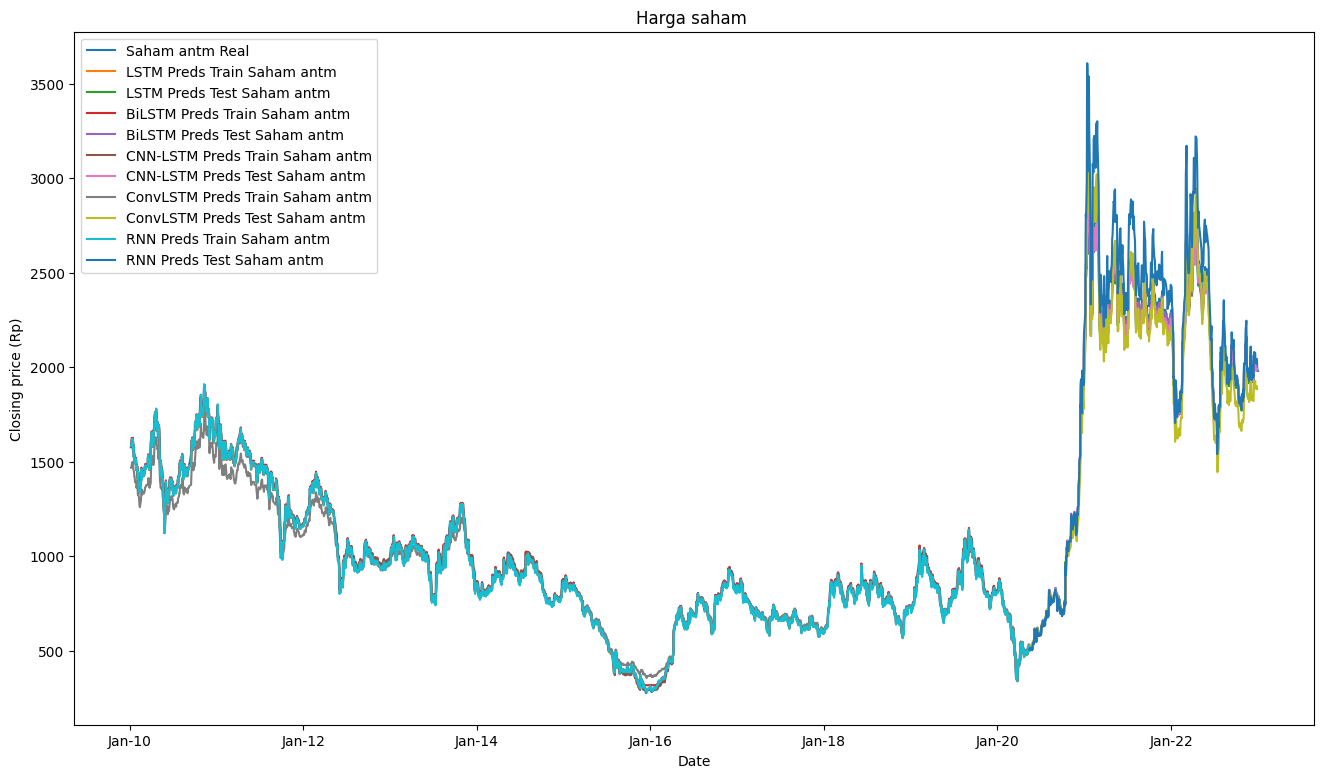

In [413]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'antm'
ax.plot(data_close.antm.index, data_close.antm, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_antm, train_plot_antm, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_antm, train_plot_antm_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_antm, train_plot_antm_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_antm, train_plot_antm_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_antm, train_plot_antm_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

## ASII

### VANILLA

In [291]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_asii = pd.DataFrame(data_close.asii)
df_asii = pd.DataFrame(scaler.fit_transform(df_asii), columns = ['asii'])

In [293]:
#reset index
# df_asii = reset_index_data(df_asii)

asii_train_size, asii_test_size = data_size(df_asii)
train_asii = df_asii.iloc[:asii_train_size,:].values
test_asii = df_asii.iloc[asii_train_size:len(df_asii),:].values


#data to supervised
X_train_asii, y_train_asii = split_sequence(train_asii, 3)
X_test_asii, y_test_asii = split_sequence(test_asii, 3)
        
# X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [294]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 32)                4352      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 4s 6ms/step - loss: 0.0481 - mae: 0.0481 - val_loss: 0.0284 - val_mae: 0.0284
Epoch 2/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 3/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0228 - mae: 0.0228 - val_loss: 0.0280 - val_mae: 0.0280
Epoch 4/150
258/258 [===========================

In [295]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii',4)

21/21 [==============================] - 0s 3ms/step
Matriks score for asii
mae score: 0.01583973979546558
r2 score 0.979161150495182
mape score 0.02859953775491361
rmse score 0.020890445599482645
round_up
mae score: 0.0158
r2 score 0.9792
mape score 0.0286
rmse score 0.0209


In [296]:
preds_asii_train = model_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_train,y_train_asii,'asii',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015755300991662995
r2 score 0.9899665181256062
mape score 0.03707940993683615
rmse score 0.021253829785516133
round_up
mae score: 0.0158
r2 score 0.99
mape score 0.0371
rmse score 0.0213


### BILSTM

In [297]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 6s 9ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 2/150
258/258 [==============================] - 2s 7ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0273 - val_mae: 0.0273
Epoch 3/150
258/258 [==============================] - 1s 6ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0274 

In [298]:
preds_asii_bidirectional = model_bidirectional_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii',4)

21/21 [==============================] - 1s 2ms/step
Matriks score for asii
mae score: 0.01576678491261672
r2 score 0.9789261007673481
mape score 0.028244891586599395
rmse score 0.020825266966101035
round_up
mae score: 0.0158
r2 score 0.9789
mape score 0.0282
rmse score 0.0208


In [299]:
preds_asii_bidirectional_train = model_bidirectional_asii.predict(X_train_asii)
matriks_evaluate(preds_asii_bidirectional_train,y_train_asii,'asii',4)

81/81 [==============================] - 0s 4ms/step
Matriks score for asii
mae score: 0.015778110775673714
r2 score 0.9898345485543443
mape score 0.03721050400626157
rmse score 0.02127518463330801
round_up
mae score: 0.0158
r2 score 0.9898
mape score 0.0372
rmse score 0.0213


### CNN-LSTM

In [304]:
df_asii_cnn = pd.DataFrame(data_close.asii)
df_asii_cnn = pd.DataFrame(scaler.fit_transform(df_asii_cnn), columns = ['asii'])

In [300]:
asii_train_size_cnn, asii_test_size_cnn = data_size(df_asii_cnn)
train_cnn_asii = df_asii_cnn.iloc[:asii_train_size,:].values
test_cnn_asii = df_asii_cnn.iloc[asii_train_size:len(df_asii_cnn),:].values

#data to supervised
X_train_asii_cnn, y_train_asii_cnn = split_sequence(train_cnn_asii, 3)
X_test_asii_cnn, y_test_asii_cnn = split_sequence(test_cnn_asii, 3)
#split to train and test
# X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [301]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, None, 3, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                     

In [302]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.023132632436407435
r2 score 0.9543710343031255
mape score 0.040321958458423866
rmse score 0.029406688467913254
round_up
mae score: 0.0231
r2 score 0.9544
mape score 0.0403
rmse score 0.0294


In [303]:
preds_asii_cnn_lstm_train = model_cnn_asii.predict(X_train_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm_train,y_train_asii_cnn,'asii',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.026871510866606132
r2 score 0.9647752208957577
mape score 0.06387191642015767
rmse score 0.03690963983022167
round_up
mae score: 0.0269
r2 score 0.9648
mape score 0.0639
rmse score 0.0369


### CONVLSTM

In [305]:
df_asii_conv = pd.DataFrame(data_close.asii)
df_asii_conv = pd.DataFrame(scaler.fit_transform(df_asii_conv), columns = ['asii'])

In [306]:
asii_train_size_conv, asii_test_size_conv = data_size(df_asii_conv)
train_conv_asii = df_asii_conv.iloc[:asii_train_size,:].values
test_conv_asii = df_asii_conv.iloc[asii_train_size:len(df_asii_conv),:].values

#data to supervised
X_train_asii_conv, y_train_asii_conv = split_sequence(train_conv_asii, 3)
X_test_asii_conv, y_test_asii_conv = split_sequence(test_conv_asii, 3)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [307]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_6 (ConvLSTM2D)  (None, 1, 2, 32)          8576      
                                                                 
 flatten_13 (Flatten)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 7s 8ms/step - loss: 0.0698 - mae: 0.0698 - val_loss: 0.0909 - val_mae: 0.0909
Epoch 2/150
258/258 [==============================] - 1s 6ms/step - loss: 0.0475 - mae: 0.0475 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 3/150
258/258 [============================

In [308]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.01522760154576541
r2 score 0.9799769376759286
mape score 0.02700549037529672
rmse score 0.020295739644614934
round_up
mae score: 0.0152
r2 score 0.98
mape score 0.027
rmse score 0.0203


In [309]:
preds_asii_conv_lstm_train = model_conv_asii.predict(X_train_asii_conv)
matriks_evaluate(preds_asii_conv_lstm_train,y_train_asii_conv,'asii',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.016569803064671488
r2 score 0.9870641249670273
mape score 0.04374180361760953
rmse score 0.02338867379572644
round_up
mae score: 0.0166
r2 score 0.9871
mape score 0.0437
rmse score 0.0234


### RNN

In [227]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_asii_rnn = pd.DataFrame(data_close.asii)
df_asii_rnn = pd.DataFrame(scaler.fit_transform(df_asii_rnn), columns = ['asii'])

In [310]:
asii_rnn_train_size, asii_rnn_test_size = data_size(df_asii_rnn)
train_rnn_asii = df_asii_rnn.iloc[:asii_rnn_train_size,:].values
test_rnn_asii = df_asii_rnn.iloc[asii_rnn_train_size:len(df_asii_rnn),:].values

#data to supervised
X_train_asii_rnn, y_train_asii_rnn = split_sequence(train_rnn_asii, 3)
X_test_asii_rnn, y_test_asii_rnn = split_sequence(test_rnn_asii, 3)

X_train_asii_rnn = reshape_data(X_train_asii_rnn,1)
X_test_asii_rnn = reshape_data(X_test_asii_rnn,1)


In [311]:
cfg_asii_rnn = [32,'relu',3,1,0.01,8,150]
model_asii_rnn,history_asii_model_rnn  = train_model_rnn(X_train_asii_rnn,y_train_asii_rnn,cfg_asii_rnn)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
258/258 [==============================] - 3s 5ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0199 - val_mae: 0.0199
Epoch 2/150
258/258 [==============================] - 1s 4ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0244 - val_mae: 0.0244
Epoch 3/150
258/258 [==============================] - 1s 3ms/step - loss: 0.0186 - mae: 0.0186 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 4/150
258/258 [===========================

In [312]:
preds_asii_rnn = model_asii_rnn.predict(X_test_asii_rnn)
matriks_evaluate(preds_asii_rnn,y_test_asii_rnn,'asii',4)

21/21 [==============================] - 0s 1ms/step
Matriks score for asii
mae score: 0.015589144823865296
r2 score 0.978843387218191
mape score 0.027435972235224027
rmse score 0.020705398256381725
round_up
mae score: 0.0156
r2 score 0.9788
mape score 0.0274
rmse score 0.0207


In [313]:
preds_asii_rnn_train = model_asii_rnn.predict(X_train_asii_rnn)
matriks_evaluate(preds_asii_rnn_train,y_train_asii_rnn,'asii',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for asii
mae score: 0.015194808496129676
r2 score 0.9905858079291491
mape score 0.035372469864092065
rmse score 0.020327225324537502
round_up
mae score: 0.0152
r2 score 0.9906
mape score 0.0354
rmse score 0.0203


### PLOT DATA SAHAM ASII

In [314]:
date = pd.DataFrame(data_close.asii.index)
train_date_asii = pd.DataFrame(date.iloc[3:asii_train_size,:].values)
test_date_asii = pd.DataFrame(date.iloc[asii_train_size:len(df_asii)-3,:].values)
#VANILA
train_plot_asii = pd.DataFrame(scaler.inverse_transform(preds_asii_train), columns=['asii'])
test_plot_asii = pd.DataFrame(scaler.inverse_transform(preds_asii), columns=['asii'])
#BILSTM
train_plot_asii_bilstm = pd.DataFrame(scaler.inverse_transform(preds_asii_bidirectional_train), columns=['asii'])
test_plot_asii_bilstm = pd.DataFrame(scaler.inverse_transform(preds_asii_bidirectional), columns=['asii'])
#CNN-LSTM
train_plot_asii_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_asii_cnn_lstm_train), columns=['asii'])
test_plot_asii_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_asii_cnn_lstm), columns=['asii'])
#CONV-LSTM
train_plot_asii_conv = pd.DataFrame(scaler.inverse_transform(preds_asii_conv_lstm_train), columns=['asii'])
test_plot_asii_conv = pd.DataFrame(scaler.inverse_transform(preds_asii_conv_lstm), columns=['asii'])
#RNN
train_plot_asii_rnn = pd.DataFrame(scaler.inverse_transform(preds_asii_rnn_train), columns=['asii'])
test_plot_asii_rnn = pd.DataFrame(scaler.inverse_transform(preds_asii_rnn), columns=['asii'])


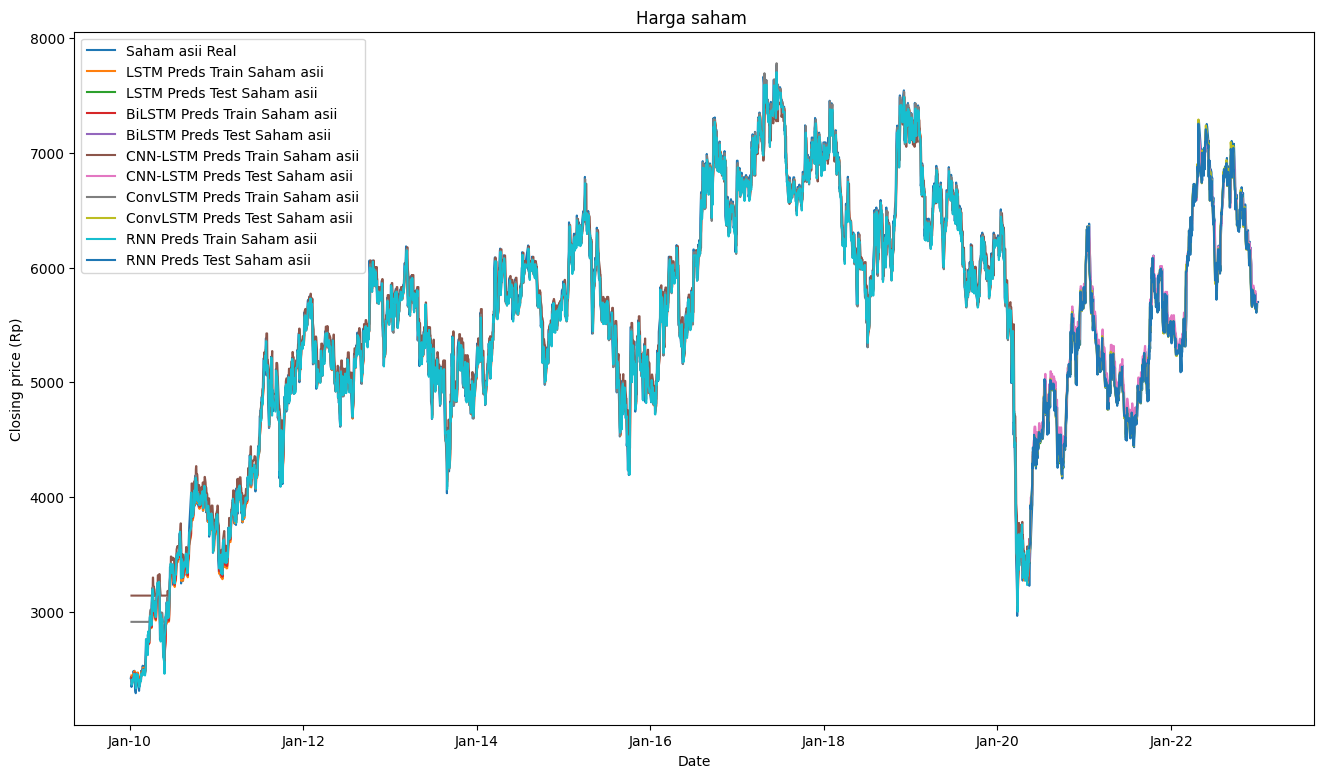

In [315]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'asii'
ax.plot(data_close.asii.index, data_close.asii, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_asii, train_plot_asii, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_asii, train_plot_asii_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_asii, train_plot_asii_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_asii, train_plot_asii_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_asii, train_plot_asii_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

## ICBP

### VANILLA

In [265]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_icbp = pd.DataFrame(data_close.icbp)
df_icbp = pd.DataFrame(scaler.fit_transform(df_icbp), columns = ['icbp'])

In [266]:
#reset index
# df_icbp = reset_index_data(df_icbp)

icbp_train_size, icbp_test_size = data_size(df_icbp)
train = df_icbp.iloc[:icbp_train_size,:].values
test = df_icbp.iloc[icbp_train_size:len(df_icbp),:].values


#data to supervised
X_train_icbp, y_train_icbp = split_sequence(train, 1)
X_test_icbp, y_test_icbp = split_sequence(test, 1)
        
# X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [267]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 8)                 320       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 3s 5ms/step - loss: 0.0618 - mae: 0.0618 - val_loss: 0.0622 - val_mae: 0.0622
Epoch 2/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 3/200
129/129 [==============================] - 0s 4ms/step - loss: 0.0091 - mae: 0.0091 - val_loss: 0.0163 - val_mae: 0.0163
Epoch 4/200
129/129 [==============================]

In [268]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.009923631129114046
r2 score 0.9626382953597813
mape score 0.013926337335013679
rmse score 0.013841049123270997
round_up
mae score: 0.0099
r2 score 0.9626
mape score 0.0139
rmse score 0.0138


In [269]:
preds_icbp_train = model_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_train,y_train_icbp,'icbp',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.007436150369613043
r2 score 0.998368870063228
mape score 0.05226681020932387
rmse score 0.011088815314691879
round_up
mae score: 0.0074
r2 score 0.9984
mape score 0.0523
rmse score 0.0111


### BILSTM

In [243]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 4s 8ms/step - loss: 0.0548 - mae: 0.0548 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 2/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0114 - mae: 0.0114 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 3/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0082 - mae: 0.0082 - val_loss: 0.0112 - va

In [244]:
preds_icbp_bidirectional = model_bidirectional_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp',4)

21/21 [==============================] - 1s 8ms/step
Matriks score for icbp
mae score: 0.010283498976491945
r2 score 0.9629084552643291
mape score 0.01447557009191101
rmse score 0.014168429862874608
round_up
mae score: 0.0103
r2 score 0.9629
mape score 0.0145
rmse score 0.0142


In [245]:
preds_icbp_bidirectional_train = model_bidirectional_icbp.predict(X_train_icbp)
matriks_evaluate(preds_icbp_bidirectional_train,y_train_icbp,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.007624022875489116
r2 score 0.9982210498010341
mape score 0.032114243359113746
rmse score 0.011530013515070745
round_up
mae score: 0.0076
r2 score 0.9982
mape score 0.0321
rmse score 0.0115


### CNN-LSTM

In [246]:
df_icbp_cnn = pd.DataFrame(data_close.icbp)
df_icbp_cnn = pd.DataFrame(scaler.fit_transform(df_icbp_cnn), columns = ['icbp'])

In [278]:
icbp_train_size_cnn, icbp_test_size_cnn = data_size(df_icbp_cnn)
train_cnn_icbp = df_icbp_cnn.iloc[:icbp_train_size,:].values
test_cnn_icbp = df_icbp_cnn.iloc[icbp_train_size:len(df_icbp_cnn),:].values

#data to supervised
X_train_icbp_cnn, y_train_icbp_cnn = split_sequence(train_cnn_icbp, 2)
X_test_icbp_cnn, y_test_icbp_cnn = split_sequence(test_cnn_icbp, 2)
#split to train and test
# X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [279]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, None, 2, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_17 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                     

In [280]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp',4)

21/21 [==============================] - 1s 2ms/step
Matriks score for icbp
mae score: 0.026492900771909998
r2 score 0.8096197424102299
mape score 0.0359355338697663
rmse score 0.029896213401232347
round_up
mae score: 0.0265
r2 score 0.8096
mape score 0.0359
rmse score 0.0299


In [281]:
preds_icbp_cnn_lstm_train = model_cnn_icbp.predict(X_train_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm_train,y_train_icbp_cnn,'icbp',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.026205060015616954
r2 score 0.9868396268889179
mape score 0.13889528530958523
rmse score 0.0306504018715312
round_up
mae score: 0.0262
r2 score 0.9868
mape score 0.1389
rmse score 0.0307


### CONVLSTM

In [282]:
df_icbp_conv = pd.DataFrame(data_close.icbp)
df_icbp_conv = pd.DataFrame(scaler.fit_transform(df_icbp_conv), columns = ['icbp'])

In [283]:
icbp_train_size_conv, icbp_test_size_conv = data_size(df_icbp_conv)
train_conv_icbp = df_icbp_conv.iloc[:icbp_train_size,:].values
test_conv_icbp = df_icbp_conv.iloc[icbp_train_size:len(df_icbp),:].values

#data to supervised
X_train_icbp_conv, y_train_icbp_conv = split_sequence(train_conv_icbp, 2)
X_test_icbp_conv, y_test_icbp_conv = split_sequence(test_conv_icbp, 2)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [284]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_5 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_11 (Flatten)        (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 5s 7ms/step - loss: 0.0511 - mae: 0.0511 - val_loss: 0.1834 - val_mae: 0.1834
Epoch 2/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0254 - val_mae: 0.0254
Epoch 3/200
129/129 [==============================] 

In [285]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.00982937970783455
r2 score 0.9601910598269706
mape score 0.013785250588133366
rmse score 0.013819257000001634
round_up
mae score: 0.0098
r2 score 0.9602
mape score 0.0138
rmse score 0.0138


In [286]:
preds_icbp_conv_lstm_train = model_conv_icbp.predict(X_train_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm_train,y_train_icbp_conv,'icbp',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.010594415271654493
r2 score 0.997506560968753
mape score 0.06839658793056144
rmse score 0.013377392595662898
round_up
mae score: 0.0106
r2 score 0.9975
mape score 0.0684
rmse score 0.0134


### RNN

In [256]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_icbp_rnn = pd.DataFrame(data_close.icbp)
df_icbp_rnn = pd.DataFrame(scaler.fit_transform(df_icbp_rnn), columns = ['icbp'])

In [257]:
icbp_rnn_train_size, icbp_rnn_test_size = data_size(df_icbp_rnn)
train_rnn = df_icbp_rnn.iloc[:icbp_rnn_train_size,:].values
test_rnn = df_icbp_rnn.iloc[icbp_rnn_train_size:len(df_icbp_rnn),:].values

#data to supervised
X_train_icbp_rnn, y_train_icbp_rnn = split_sequence(train_rnn, 1)
X_test_icbp_rnn, y_test_icbp_rnn = split_sequence(test_rnn, 1)

X_train_icbp_rnn = reshape_data(X_train_icbp_rnn,1)
X_test_icbp_rnn = reshape_data(X_test_icbp_rnn,1)


In [259]:
cfg_icbp_rnn = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn,history_icbp_model_rnn  = train_model_rnn(X_train_icbp_rnn,y_train_icbp_rnn,cfg_icbp_rnn)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_22 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 2s 6ms/step - loss: 0.0081 - mae: 0.0081 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 2/200
129/129 [==============================] - 0s 4ms/step - loss: 0.0076 - mae: 0.0076 - val_loss: 0.0217 - val_mae: 0.0217
Epoch 3/200
129/129 [==============================] - 0s 4ms/step - loss: 0.0078 - mae: 0.0078 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 4/200
129/129 [==============================] -

In [260]:
preds_icbp_rnn = model_icbp_rnn.predict(X_test_icbp_rnn)
matriks_evaluate(preds_icbp_rnn,y_test_icbp_rnn,'icbp',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for icbp
mae score: 0.00998338304499171
r2 score 0.96248951748901
mape score 0.013983524957183665
rmse score 0.013868597412795372
round_up
mae score: 0.01
r2 score 0.9625
mape score 0.014
rmse score 0.0139


In [261]:
preds_icbp_rnn_train = model_icbp_rnn.predict(X_train_icbp_rnn)
matriks_evaluate(preds_icbp_rnn_train,y_train_icbp_rnn,'icbp',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for icbp
mae score: 0.006728978082821827
r2 score 0.998463105910085
mape score 0.029036097495119165
rmse score 0.010712973998428757
round_up
mae score: 0.0067
r2 score 0.9985
mape score 0.029
rmse score 0.0107


### PLOT DATA SAHAM ICBP

In [287]:
date = pd.DataFrame(data_close.icbp.index)
train_date_icbp = pd.DataFrame(date.iloc[1:icbp_train_size,:].values)
test_date_icbp = pd.DataFrame(date.iloc[icbp_train_size:len(df_icbp)-1,:].values)
train_date_icbp_cnnconv = pd.DataFrame(date.iloc[2:icbp_train_size,:].values)
test_date_icbp_cnnconv = pd.DataFrame(date.iloc[icbp_train_size:len(df_icbp)-2,:].values)
#VANILA
train_plot_icbp = pd.DataFrame(scaler.inverse_transform(preds_icbp_train), columns=['icbp'])
test_plot_icbp = pd.DataFrame(scaler.inverse_transform(preds_icbp), columns=['icbp'])
#BILSTM
train_plot_icbp_bilstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_bidirectional_train), columns=['icbp'])
test_plot_icbp_bilstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_bidirectional), columns=['icbp'])
#CNN-LSTM
train_plot_icbp_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_cnn_lstm_train), columns=['icbp'])
test_plot_icbp_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_icbp_cnn_lstm), columns=['icbp'])
#CONV-LSTM
train_plot_icbp_conv = pd.DataFrame(scaler.inverse_transform(preds_icbp_conv_lstm_train), columns=['icbp'])
test_plot_icbp_conv = pd.DataFrame(scaler.inverse_transform(preds_icbp_conv_lstm), columns=['icbp'])
#RNN
train_plot_icbp_rnn = pd.DataFrame(scaler.inverse_transform(preds_icbp_rnn_train), columns=['icbp'])
test_plot_icbp_rnn = pd.DataFrame(scaler.inverse_transform(preds_icbp_rnn), columns=['icbp'])


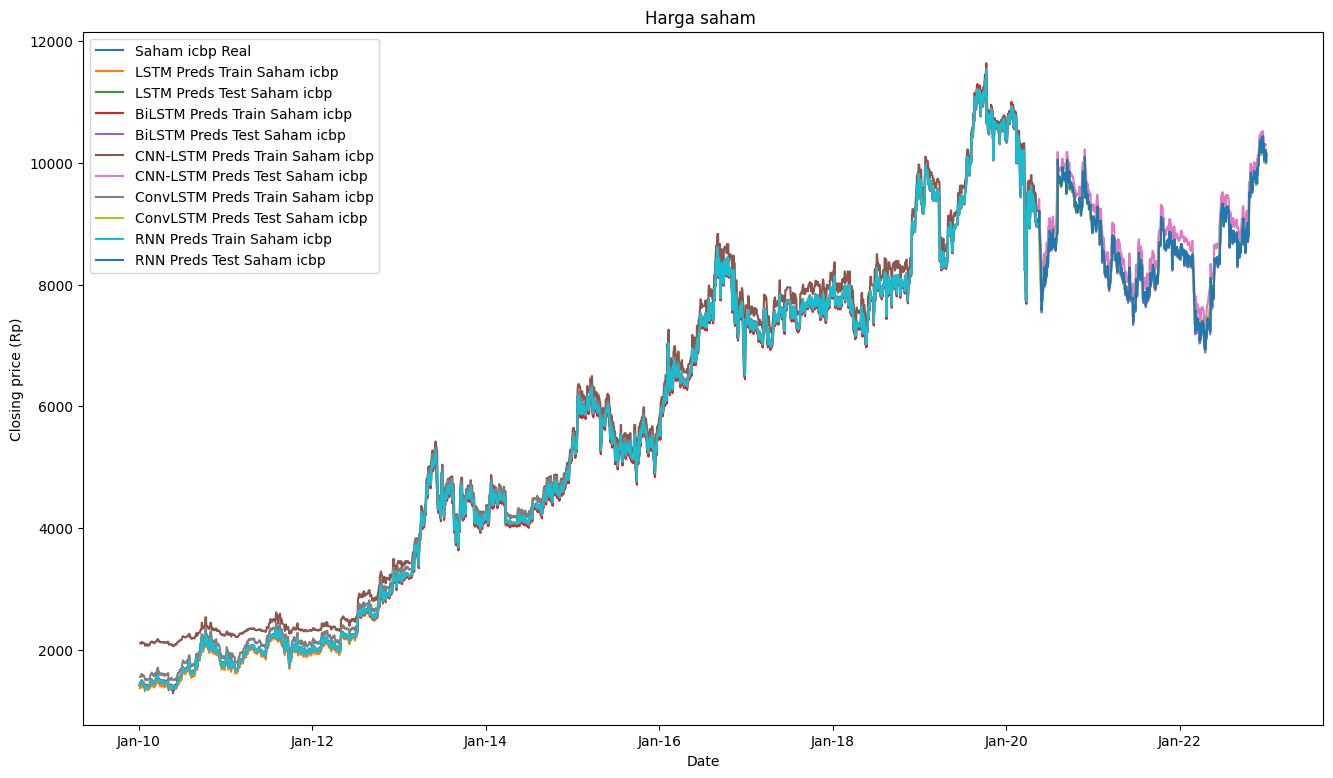

In [288]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'icbp'
ax.plot(data_close.icbp.index, data_close.icbp, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_icbp, train_plot_icbp, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_icbp, train_plot_icbp_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_icbp_cnnconv, train_plot_icbp_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_cnnconv, test_plot_icbp_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_icbp_cnnconv, train_plot_icbp_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_cnnconv, test_plot_icbp_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_icbp, train_plot_icbp_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

## JSMR

### VANILLA

In [316]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_jsmr = pd.DataFrame(data_close.jsmr)
df_jsmr = pd.DataFrame(scaler.fit_transform(df_jsmr), columns = ['jsmr'])

In [317]:
#reset index
# df_jsmr = reset_index_data(df_jsmr)

jsmr_train_size, jsmr_test_size = data_size(df_jsmr)
train_jsmr = df_jsmr.iloc[:jsmr_train_size,:].values
test_jsmr = df_jsmr.iloc[jsmr_train_size:len(df_jsmr),:].values


#data to supervised
X_train_jsmr, y_train_jsmr = split_sequence(train_jsmr, 1)
X_test_jsmr, y_test_jsmr = split_sequence(test_jsmr, 1)
        
# X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [318]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 8)                 320       
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 2s 5ms/step - loss: 0.1123 - mae: 0.1123 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 2/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 3/200
129/129 [==============================] - 0s 3ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 4/200
129/129 [==============================]

In [319]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.010859633185408854
r2 score 0.9607189395436027
mape score 0.024467041599721188
rmse score 0.014872748863994846
round_up
mae score: 0.0109
r2 score 0.9607
mape score 0.0245
rmse score 0.0149


In [320]:
preds_jsmr_train = model_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_train,y_train_jsmr,'jsmr',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.011948657886788252
r2 score 0.9942372677662932
mape score 0.029746294146479
rmse score 0.016981388543767885
round_up
mae score: 0.0119
r2 score 0.9942
mape score 0.0297
rmse score 0.017


### BILSTM

In [321]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 4s 8ms/step - loss: 0.1358 - mae: 0.1358 - val_loss: 0.0196 - val_mae: 0.0196
Epoch 2/200
129/129 [==============================] - 1s 5ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0227 - val_mae: 0.0227
Epoch 3/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0183 - va

In [322]:
preds_jsmr_bidirectional = model_bidirectional_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.011594140682902355
r2 score 0.9544497588604376
mape score 0.026358462296342946
rmse score 0.01582529604400733
round_up
mae score: 0.0116
r2 score 0.9544
mape score 0.0264
rmse score 0.0158


In [323]:
preds_jsmr_bidirectional_train = model_bidirectional_jsmr.predict(X_train_jsmr)
matriks_evaluate(preds_jsmr_bidirectional_train,y_train_jsmr,'jsmr',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.013761012296941691
r2 score 0.9929795984113845
mape score 0.04645060011597093
rmse score 0.01871097164531862
round_up
mae score: 0.0138
r2 score 0.993
mape score 0.0465
rmse score 0.0187


### CNN-LSTM

In [353]:
df_jsmr_cnn = pd.DataFrame(data_close.jsmr)
df_jsmr_cnn = pd.DataFrame(scaler.fit_transform(df_jsmr_cnn), columns = ['jsmr'])

In [354]:
jsmr_train_size_cnn, jsmr_test_size_cnn = data_size(df_jsmr_cnn)
train_cnn_jsmr = df_jsmr_cnn.iloc[:jsmr_train_size,:].values
test_cnn_jsmr = df_jsmr_cnn.iloc[jsmr_train_size:len(df_jsmr_cnn),:].values

#data to supervised
X_train_jsmr_cnn, y_train_jsmr_cnn = split_sequence(train_cnn_jsmr, 4)
X_test_jsmr_cnn, y_test_jsmr_cnn = split_sequence(test_cnn_jsmr, 4)
#split to train and test
# X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,1,4)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,1,4)

In [355]:
cfg_jsmr_cnn = [8,'relu',4,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model,  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, None, 4, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, None, 2, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, None, 128)        0         
 stributed)                                                      
                                                                 
 lstm_25 (LSTM)              (None, 8)                 4384      
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                     

In [356]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.013129717040657664
r2 score 0.9457830300771286
mape score 0.029430286190348397
rmse score 0.01762547359460637
round_up
mae score: 0.0131
r2 score 0.9458
mape score 0.0294
rmse score 0.0176


In [357]:
preds_jsmr_cnn_lstm_train = model_cnn_jsmr.predict(X_train_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm_train,y_train_jsmr_cnn,'jsmr',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for jsmr
mae score: 0.0161041092520381
r2 score 0.9899418126450245
mape score 0.04636862747163571
rmse score 0.021973285123686917
round_up
mae score: 0.0161
r2 score 0.9899
mape score 0.0464
rmse score 0.022


### CONVLSMT

In [326]:
df_jsmr_conv = pd.DataFrame(data_close.jsmr)
df_jsmr_conv = pd.DataFrame(scaler.fit_transform(df_jsmr_conv), columns = ['jsmr'])

In [327]:
jsmr_train_size_conv, jsmr_test_size_conv = data_size(df_jsmr_conv)
train_conv_jsmr = df_jsmr_conv.iloc[:jsmr_train_size,:].values
test_conv_jsmr = df_jsmr_conv.iloc[jsmr_train_size:len(df_jsmr),:].values

#data to supervised
X_train_jsmr_conv, y_train_jsmr_conv = split_sequence(train_conv_jsmr, 4)
X_test_jsmr_conv, y_test_jsmr_conv = split_sequence(test_conv_jsmr, 4)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [328]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_7 (ConvLSTM2D)  (None, 1, 3, 8)           608       
                                                                 
 flatten_14 (Flatten)        (None, 24)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 25        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 5s 9ms/step - loss: 0.1114 - mae: 0.1114 - val_loss: 0.0519 - val_mae: 0.0519
Epoch 2/200
129/129 [==============================] - 1s 5ms/step - loss: 0.0456 - mae: 0.0456 - val_loss: 0.0585 - val_mae: 0.0585
Epoch 3/200
129/129 [==============================] 

In [329]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.012443166888223145
r2 score 0.9481409462879383
mape score 0.02823630524294512
rmse score 0.017120630127845666
round_up
mae score: 0.0124
r2 score 0.9481
mape score 0.0282
rmse score 0.0171


In [330]:
preds_jsmr_conv_lstm_train = model_conv_jsmr.predict(X_train_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm_train,y_train_jsmr_conv,'jsmr',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for jsmr
mae score: 0.01410538180781149
r2 score 0.9921763870978458
mape score 0.044208239685987506
rmse score 0.019867471592422144
round_up
mae score: 0.0141
r2 score 0.9922
mape score 0.0442
rmse score 0.0199


### RNN

In [331]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_jsmr_rnn = pd.DataFrame(data_close.jsmr)
df_jsmr_rnn = pd.DataFrame(scaler.fit_transform(df_jsmr_rnn), columns = ['jsmr'])

In [332]:
jsmr_rnn_train_size, jsmr_rnn_test_size = data_size(df_jsmr_rnn)
train_rnn = df_jsmr_rnn.iloc[:jsmr_rnn_train_size,:].values
test_rnn = df_jsmr_rnn.iloc[jsmr_rnn_train_size:len(df_jsmr_rnn),:].values

#data to supervised
X_train_jsmr_rnn, y_train_jsmr_rnn = split_sequence(train_rnn, 1)
X_test_jsmr_rnn, y_test_jsmr_rnn = split_sequence(test_rnn, 1)

X_train_jsmr_rnn = reshape_data(X_train_jsmr_rnn,1)
X_test_jsmr_rnn = reshape_data(X_test_jsmr_rnn,1)


In [333]:
cfg_jsmr_rnn = [8,'relu',1,1,0.01,16,200]
model_jsmr_rnn,history_jsmr_model_rnn  = train_model_rnn(X_train_jsmr_rnn,y_train_jsmr_rnn,cfg_jsmr_rnn)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
129/129 [==============================] - 2s 6ms/step - loss: 0.0468 - mae: 0.0468 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 2/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 3/200
129/129 [==============================] - 1s 4ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0160 - val_mae: 0.0160
Epoch 4/200
129/129 [==============================] -

In [334]:
preds_jsmr_rnn = model_jsmr_rnn.predict(X_test_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn,y_test_jsmr_rnn,'jsmr',4)

21/21 [==============================] - 1s 3ms/step
Matriks score for jsmr
mae score: 0.011139968139180643
r2 score 0.9598645765205059
mape score 0.025387031074884762
rmse score 0.015212686141718708
round_up
mae score: 0.0111
r2 score 0.9599
mape score 0.0254
rmse score 0.0152


In [335]:
preds_jsmr_rnn_train = model_jsmr_rnn.predict(X_train_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn_train,y_train_jsmr_rnn,'jsmr',4)

81/81 [==============================] - 0s 3ms/step
Matriks score for jsmr
mae score: 0.012056967777834078
r2 score 0.9942794201847094
mape score 0.03350017812816961
rmse score 0.01710629738133696
round_up
mae score: 0.0121
r2 score 0.9943
mape score 0.0335
rmse score 0.0171


### PLOT DATA SAHAM JSMR

In [358]:
date = pd.DataFrame(data_close.jsmr.index)
train_date_jsmr = pd.DataFrame(date.iloc[1:jsmr_train_size,:].values)
test_date_jsmr = pd.DataFrame(date.iloc[jsmr_train_size:len(df_jsmr)-1,:].values)
train_date_jsmr_cnnconv = pd.DataFrame(date.iloc[4:jsmr_train_size,:].values)
test_date_jsmr_cnnconv = pd.DataFrame(date.iloc[jsmr_train_size:len(df_jsmr)-4,:].values)
#VANILA
train_plot_jsmr = pd.DataFrame(scaler.inverse_transform(preds_jsmr_train), columns=['jsmr'])
test_plot_jsmr = pd.DataFrame(scaler.inverse_transform(preds_jsmr), columns=['jsmr'])
#BILSTM
train_plot_jsmr_bilstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_bidirectional_train), columns=['jsmr'])
test_plot_jsmr_bilstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_bidirectional), columns=['jsmr'])
#CNN-LSTM
train_plot_jsmr_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_cnn_lstm_train), columns=['jsmr'])
test_plot_jsmr_cnnlstm = pd.DataFrame(scaler.inverse_transform(preds_jsmr_cnn_lstm), columns=['jsmr'])
#CONV-LSTM
train_plot_jsmr_conv = pd.DataFrame(scaler.inverse_transform(preds_jsmr_conv_lstm_train), columns=['jsmr'])
test_plot_jsmr_conv = pd.DataFrame(scaler.inverse_transform(preds_jsmr_conv_lstm), columns=['jsmr'])
#RNN
train_plot_jsmr_rnn = pd.DataFrame(scaler.inverse_transform(preds_jsmr_rnn_train), columns=['jsmr'])
test_plot_jsmr_rnn = pd.DataFrame(scaler.inverse_transform(preds_jsmr_rnn), columns=['jsmr'])


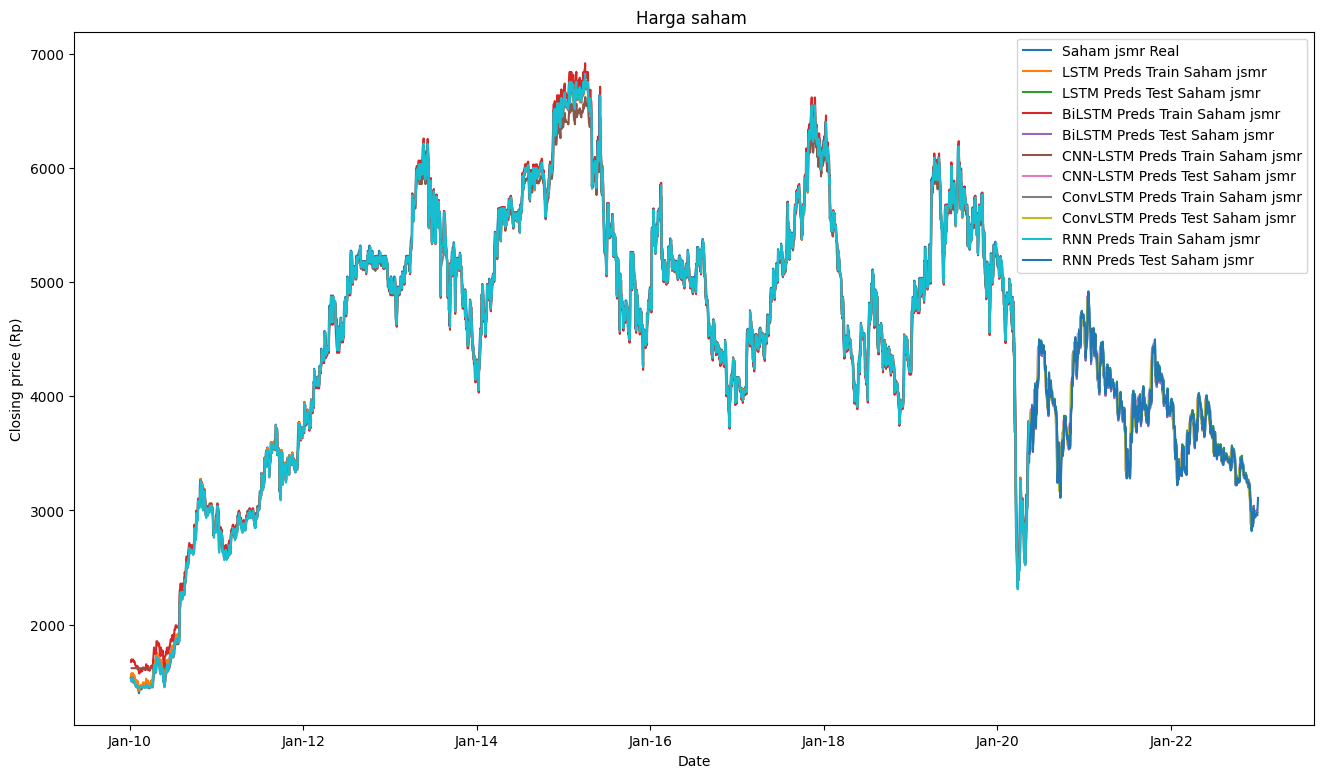

In [359]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))
name = 'jsmr'
ax.plot(data_close.jsmr.index, data_close.jsmr, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_jsmr, train_plot_jsmr, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_jsmr, train_plot_jsmr_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_jsmr, train_plot_jsmr_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr_rnn, label='RNN Preds Test Saham {}'.format(name))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

## PLOT DATA SAHAM BERDASARKAN MODEL

## PLOT MODEL TERBAIK BERDASARKAN SAHAM

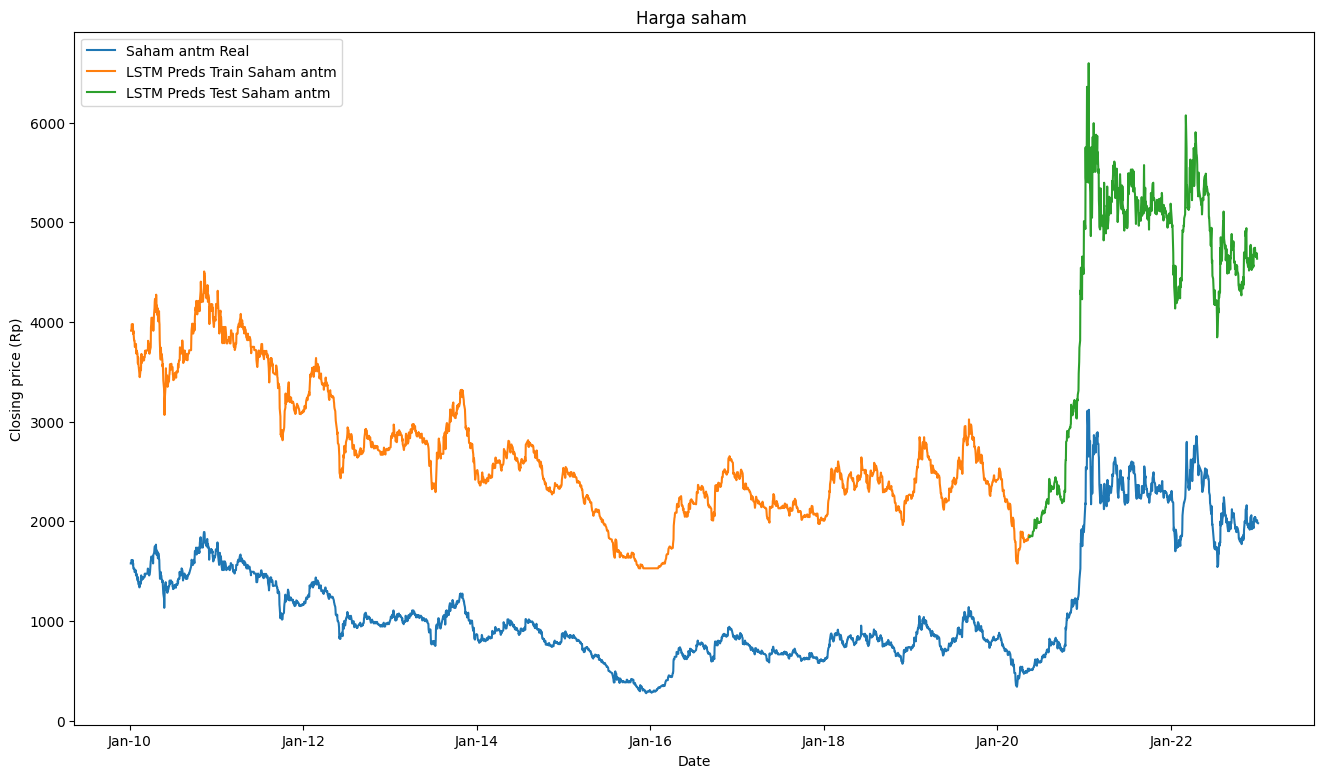

In [367]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

#ANTM
#VANILA
ax.plot(data_close.antm.index, data_close.antm, label='Saham {} Real'.format('antm'))
ax.plot(train_date_antm, train_plot_antm, label='LSTM Preds Train Saham {}'.format('antm'))
ax.plot(test_date_antm, test_plot_antm, label='LSTM Preds Test Saham {}'.format('antm'))

# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

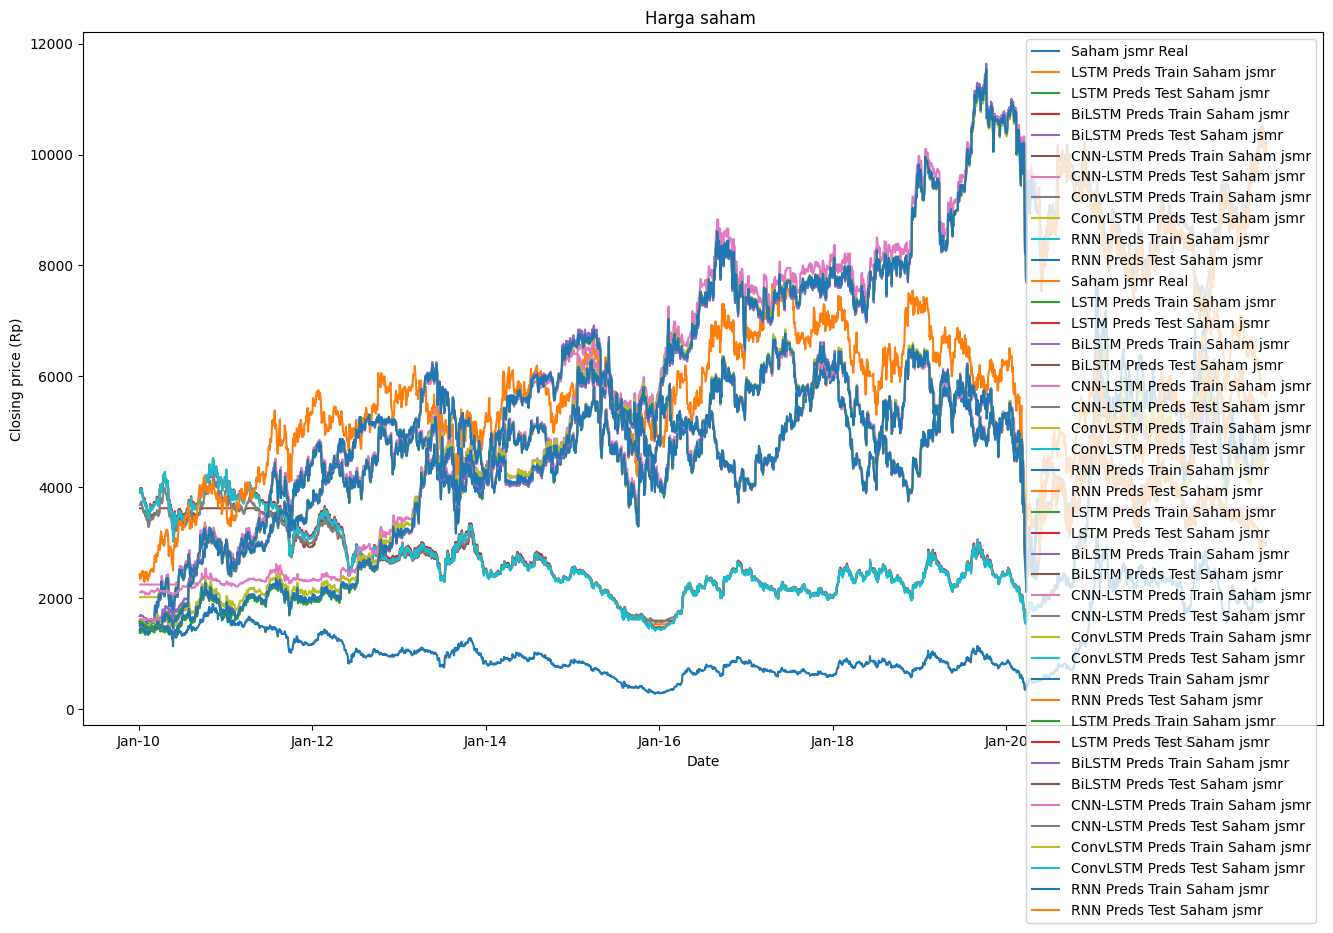

In [364]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

#ANTM
ax.plot(data_close.antm.index, data_close.antm, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_antm, train_plot_antm, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_antm, train_plot_antm_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_antm, train_plot_antm_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_antm, train_plot_antm_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_antm, train_plot_antm_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_antm, test_plot_antm_rnn, label='RNN Preds Test Saham {}'.format(name))

#ASII
ax.plot(data_close.asii.index, data_close.asii, label='Saham {} Real'.format(name))
#VANILA LSTM
ax.plot(train_date_asii, train_plot_asii, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_asii, train_plot_asii_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_asii, train_plot_asii_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_asii, train_plot_asii_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_asii, train_plot_asii_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_asii, test_plot_asii_rnn, label='RNN Preds Test Saham {}'.format(name))

#ICBP
#VANILA LSTM
ax.plot(train_date_icbp, train_plot_icbp, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_icbp, train_plot_icbp_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_icbp_cnnconv, train_plot_icbp_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_cnnconv, test_plot_icbp_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_icbp_cnnconv, train_plot_icbp_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp_cnnconv, test_plot_icbp_conv, label='ConvLSTM Preds Test Saham {}'.format(name))

#RNN
ax.plot(train_date_icbp, train_plot_icbp_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_icbp, test_plot_icbp_rnn, label='RNN Preds Test Saham {}'.format(name))
#JSMR
ax.plot(train_date_jsmr, train_plot_jsmr, label='LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr, label='LSTM Preds Test Saham {}'.format(name))
#BILSTM
ax.plot(train_date_jsmr, train_plot_jsmr_bilstm, label='BiLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr_bilstm, label='BiLSTM Preds Test Saham {}'.format(name))
#CNN-LSTM
ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_cnnlstm, label='CNN-LSTM Preds Test Saham {}'.format(name))
#CONVLSTM
ax.plot(train_date_jsmr_cnnconv, train_plot_jsmr_conv, label='ConvLSTM Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr_cnnconv, test_plot_jsmr_conv, label='ConvLSTM Preds Test Saham {}'.format(name))
#RNN
ax.plot(train_date_jsmr, train_plot_jsmr_rnn, label='RNN Preds Train Saham {}'.format(name))
ax.plot(test_date_jsmr, test_plot_jsmr_rnn, label='RNN Preds Test Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()